In [183]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

In [169]:
# Read in the data
df = pd.read_csv('../data/Corona_train.csv') 
print(df) 

          ID Sentiment                                        CoronaTweet
0      22979  Positive  I see all kinds of academics already whipping ...
1       9880  Negative  @HenrySmithUK can you raise with Boris please ...
2      35761  Negative  It s a confusing odd time for the shopping pub...
3      37968  Positive  Blog Summary: The Impact of COVID-19 on the Ca...
4      19709   Neutral  ??????? ??????? ???\r\r\nWaiting in a long Que...
...      ...       ...                                                ...
37859  20253   Neutral  DOUBLE TAP ??IF YOU REMEMBER BEING EMPLOYED?\r...
37860  38926  Positive  Struggling to understand why supermarkets or f...
37861  35889  Positive  For anyone interested in the checklist on cons...
37862  40641  Positive  Do you agree with the hypothesis that Indian s...
37863  26063   Neutral  In Richmond, local boutiques and thrift stores...

[37864 rows x 3 columns]


In [187]:
df["splitWords"] = df["CoronaTweet"][:].str.split(" ")
# print(df)
# empty set
no_of_labels = 3 
set_of_words = set()
sets = [set() for i in range(no_of_labels)] 
frequencies = dict() 

In [171]:
# Negative -> 0, Neutral -> 1, Positive -> 2 
#prob_j_0, prob_j_1, prob_j_2 
# prob_j_i = no of occurences of word j in text of class i + 1 / total no of words in class i + |V| 
# |V| = size of dictionary 



In [188]:
# computing frequencies 


SIZES = [0, 0, 0]

for index, row in df.iterrows():
    if (row["Sentiment"] == "Positive"):
        row["Sentiment"] = 2
    elif (row["Sentiment"] == "Neutral"):
        row["Sentiment"] = 1
    else:
        row["Sentiment"] = 0
    i = row["Sentiment"] # i is class 
    for word in row["splitWords"]:
            if (word == "")  : continue
            SIZES[i] += 1
            if (word in set_of_words):
                 frequencies[word][i] += 1
            else:
                set_of_words.add(word)
                frequencies[word] = [0,0,0]
            sets[i].add(word)

SIZE = len(set_of_words) 
print(SIZE) 

135814


In [173]:
# computing log probabilities 
probabilities = dict()
log_probabilities = dict()

for word in set_of_words:
    probabilities[word] = [0,0,0]
    log_probabilities[word] = [0,0,0] 
    for i in range(3):
        probabilities[word][i] = (frequencies[word][i] + 1) / (SIZES[i] + SIZE)
        log_probabilities[word][i] = math.log(probabilities[word][i])


In [174]:

# for (word, prob) in log_probabilities.items():
#     print(word) 
#     if (len(word) == 0): print("found")
#     # break 
# # print(frequencies[""])

y_prob = [SIZES[0]/SIZE, SIZES[1]/SIZE, SIZES[2]/SIZE]
y_log_prob = [math.log(y_prob[0]), math.log(y_prob[1]), math.log(y_prob[2])]     


In [175]:
def compute_canonical_log_prob(text, label, log_probabilities, set_of_words): # ignores P(x) in P(y | x) = P(x|y) * P(y)/ P(x) 
    word_list = text.split(" ")
    log_prob = 0 
    for word in word_list:
        if (word == "") : continue # ignore empty strings 
        if (word in set_of_words):
            log_prob += log_probabilities[word][label] 
        else:
            log_prob -= math.log((SIZES[label] + SIZE))  # prob is 1 / (SIZES[label] + SIZE) 
    log_prob += y_log_prob[label] 
    return log_prob 

In [176]:
def predictor(text,log_probabilities, set_of_words, SIZES):
    no_of_labels = 3
    for word,probs in log_probabilities.items():
        no_of_labels = len(log_probabilities[word]) 
        break 
    
    log_probs = [compute_canonical_log_prob(text, i, log_probabilities, set_of_words) for i in range(no_of_labels)] 
    max_prob = log_probs[0] 
    max_label = 0 

    for i in range(no_of_labels):
        if (log_probs[i] > max_prob):
            max_prob = log_probs[i]
            max_label = i
        elif (log_probs[i] == max_prob):
            max_label = max_label if (SIZES[max_label] > SIZES[i])  else i 
    return max_label


In [210]:
def compute_accuracy(df, log_probabilities, set_of_words, SIZES, confusion_matrix = None ): # input is a dataframe
    correct = 0 
    for idx,rows in df.iterrows():
        prediction = predictor(rows["CoronaTweet"], log_probabilities, set_of_words, SIZES)
        # print(f"{prediction} {rows['Sentiment']}")
        rows["Sentiment"] = 0 if (rows["Sentiment"] == "Negative") else 2 if (rows["Sentiment"] == "Positive") else 1
        confusion_matrix[rows["Sentiment"]][prediction] += 1 
        if (prediction == rows["Sentiment"]):
            correct += 1
    return correct / len(df) 



In [178]:
training_accuracy = compute_accuracy(df, log_probabilities, set_of_words, SIZES)
print(training_accuracy)

0.7507923093175576


In [179]:
df_test = pd.read_csv('../data/Corona_validation.csv') 
test_accuracy = compute_accuracy(df_test, log_probabilities, set_of_words, SIZES)
print(test_accuracy)

0.6656544184634072


In [185]:
# visualising with a word cloud
from wordcloud import  WordCloud, STOPWORDS
stopwords = set(STOPWORDS) 
print(stopwords)

{'that', "he's", 'between', 'at', "i'll", 'k', "we'll", 'which', 'from', "there's", 'the', "wasn't", 'http', "they'd", "shan't", 'yourself', "i'm", 'very', 'on', "she'd", "wouldn't", 'but', 'herself', 'while', 'been', 'is', 'nor', "why's", "you're", "when's", "isn't", "let's", 'we', 'has', 'as', 'r', 'could', 'such', 'can', 'off', 'against', 'each', "hasn't", 'so', 'some', 'else', 'any', 'of', 'should', 'their', 'therefore', 'and', 'where', 'why', 'be', 'himself', 'me', "mustn't", 'through', 'after', 'they', 'those', 'who', "it's", 'to', 'am', 'my', "i've", 'few', 'yourselves', 'also', 'his', "aren't", "here's", "can't", 'them', 'have', 'cannot', 'com', 'then', 'own', 'with', "we're", "won't", 'ought', 'what', "you've", "she's", 'her', 'over', "we'd", "didn't", "he'd", 'just', "hadn't", 'there', 'by', "doesn't", "don't", 'once', "shouldn't", 'until', 'up', 'above', 'having', 'this', 'not', 'i', 'was', 'you', 'these', 'www', 'again', 'in', 'did', 'an', 'ever', "what's", 'a', "that's", "

In [192]:

def get_wordcloud(label, database, max_words = 1000000):
    wc = WordCloud(background_color="white", max_words = max_words, stopwords=stopwords) 
    wc.generate(database) 

    wc.to_file(f"wordcloud_{label}.png")

    fig = plt.figure() 
    fig.set_figheight(18) 
    fig.set_figwidth(14) 
    
    plt.imshow(wc, interpolation='bilinear') 
    plt.axis("off")
    plt.show()


In [194]:
print(sets[0])
for i in range(no_of_labels):
    get_wordcloud(i, " ".join(sets[i])) 

In [196]:
def random_predictor(text, no_of_labels):
    x = np.random.randint(0,no_of_labels) 
    assert(x >= 0 and x < 3)
    return x 

In [197]:
def always_positive_predictor(text, no_of_labels): 
    return no_of_labels - 1 

In [208]:
def compute_random_predictor_accuracy(df, no_of_labels, confusion_matrix = None):
    correct  = 0 
    for idx,rows in df.iterrows():
        prediction = random_predictor(rows["CoronaTweet"], no_of_labels) 
        rows["Sentiment"] = 0 if (rows["Sentiment"] == "Negative") else 2 if (rows["Sentiment"] == "Positive") else 1
        confusion_matrix[rows["Sentiment"]][prediction] += 1 
        if (prediction == rows["Sentiment"]):
            correct += 1
    return correct / len(df)

In [209]:
def compute_allpositive_predictor_accuracy(df, no_of_labels, confusion_matrix = None):
    correct  = 0 
    for idx,rows in df.iterrows():
        prediction = always_positive_predictor(rows["CoronaTweet"], no_of_labels) 
        rows["Sentiment"] = 0 if (rows["Sentiment"] == "Negative") else 2 if (rows["Sentiment"] == "Positive") else 1
        confusion_matrix[rows["Sentiment"]][prediction] += 1 
        if (prediction == rows["Sentiment"]):
            correct += 1
    return correct / len(df)

In [203]:
random_accuracy = compute_random_predictor_accuracy(df_test, no_of_labels)
allpositive_accuracy = compute_allpositive_predictor_accuracy(df_test, no_of_labels) 

In [205]:
print(random_accuracy) 
print(allpositive_accuracy)
print(f"improvement over random baseline is {test_accuracy - random_accuracy}")
print(f"improvement over all positive baseline is {test_accuracy - allpositive_accuracy}")


0.3328272092317036
0.4385059216519891
improvement over random baseline is 0.3328272092317036
improvement over all positive baseline is 0.22714849681141813


In [233]:
# drawing the confusion matrix 
import seaborn as sn

def draw_confusion_matrix(confusion_matrix, name):
    correct = 0 
    total = 0 
    fig, ax = plt.subplots(figsize=(10,10))
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3) 
    max_diag = 0 
    max_diag_label = 0
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            total += confusion_matrix[i,j]
            if (i == j) : 
                correct += confusion_matrix[i,j]
                if (max_diag < confusion_matrix[i,j]):
                    max_diag = confusion_matrix[i,j]
                    max_diag_label = i
 
            ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
     
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.savefig(f"confusion_matrix_{name}.png")
    # plt.show()
    print(f"accuracy is {correct/total}")
    print(f"label with max diagonal is {max_diag_label}")


accuracy is 0.7507923093175576
label with max diagonal is 2
accuracy is 0.6656544184634072
label with max diagonal is 2


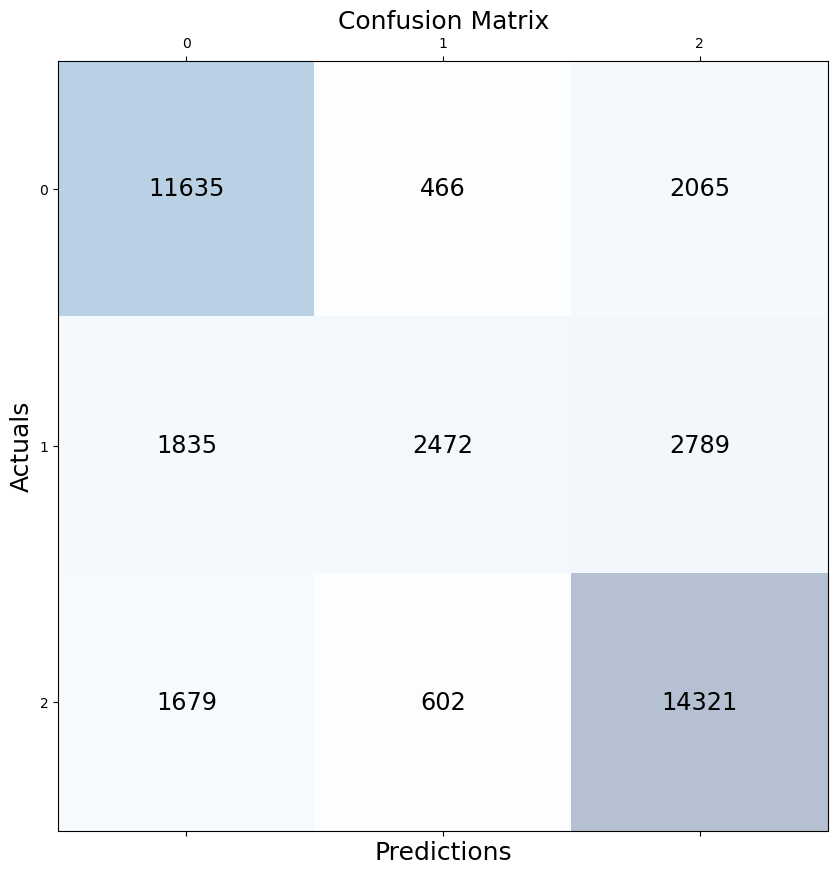

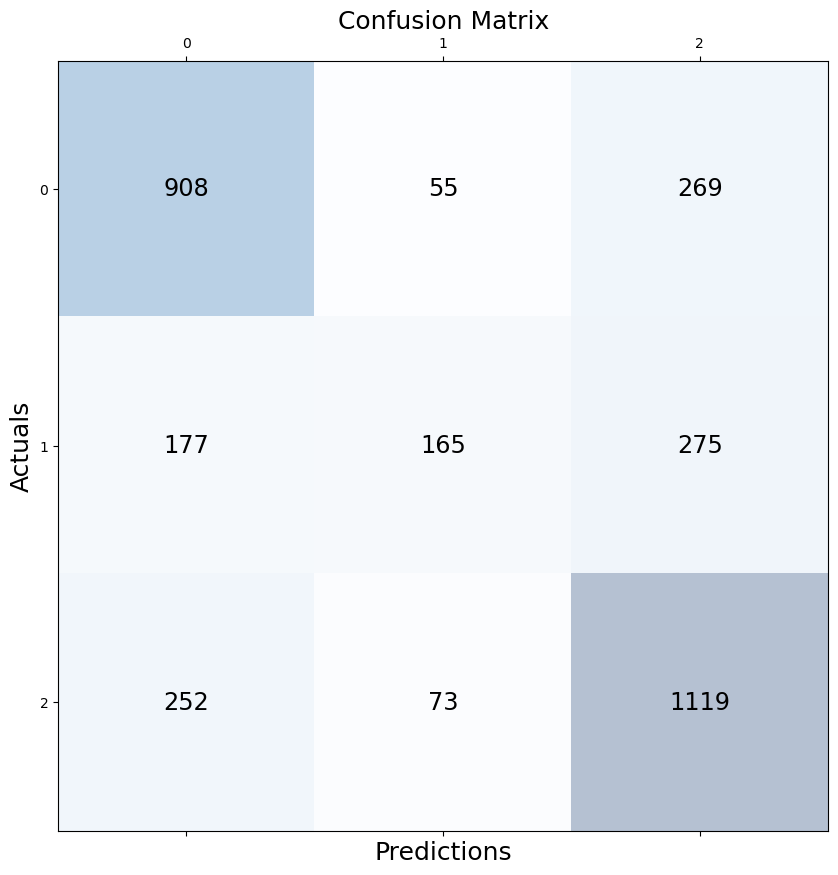

In [234]:
training_cm = np.array([ [0 for i in range(no_of_labels)] for j in range(no_of_labels)])
test_cm = np.array([ [0 for i in range(no_of_labels)] for j in range(no_of_labels)])

compute_accuracy(df, log_probabilities, set_of_words, SIZES, training_cm)
compute_accuracy(df_test, log_probabilities, set_of_words, SIZES, test_cm) 

draw_confusion_matrix(training_cm, "og_training")
draw_confusion_matrix(test_cm, "og_test")

accuracy is 0.32948679016094745
label with max diagonal is 2
accuracy is 0.4385059216519891
label with max diagonal is 2
accuracy is 0.33446017325163746
label with max diagonal is 2
accuracy is 0.4384639763363617
label with max diagonal is 2


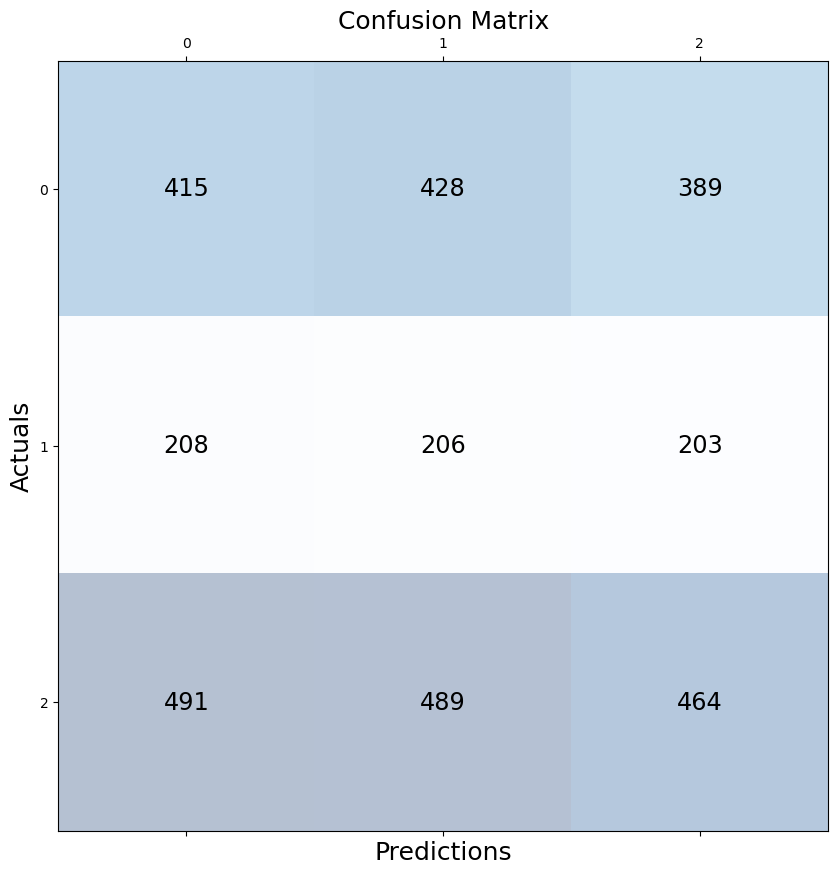

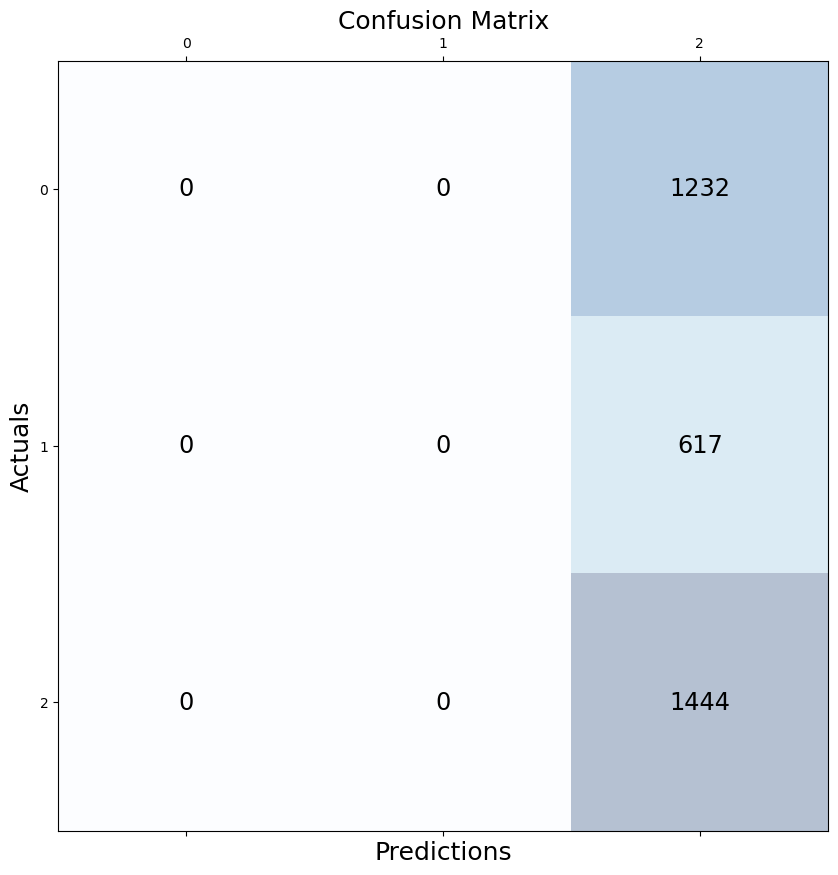

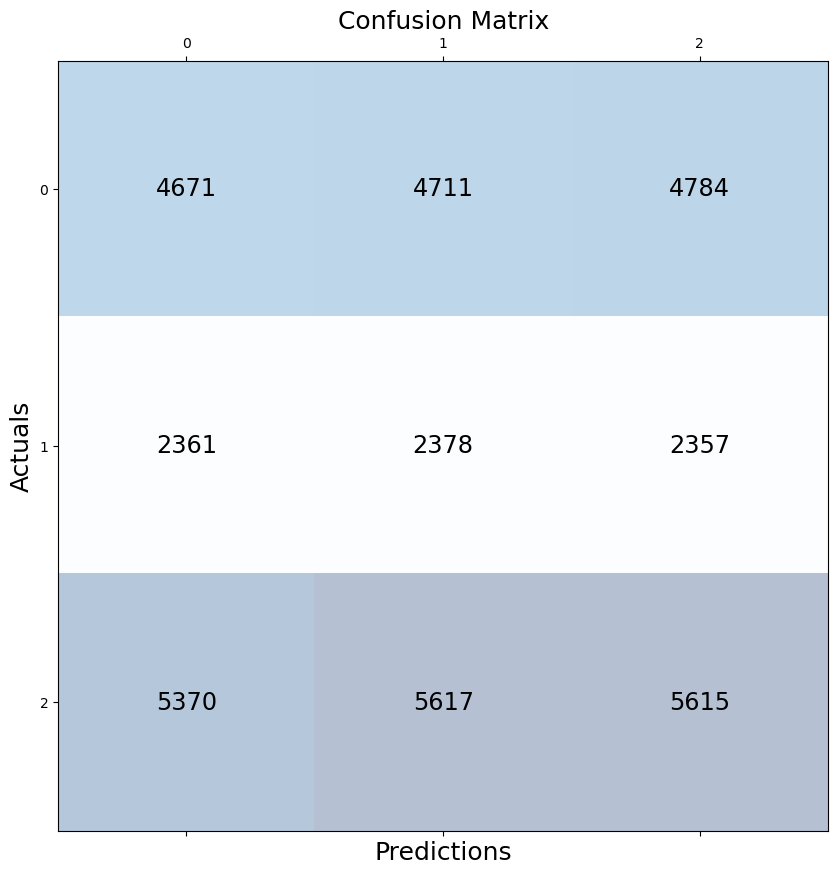

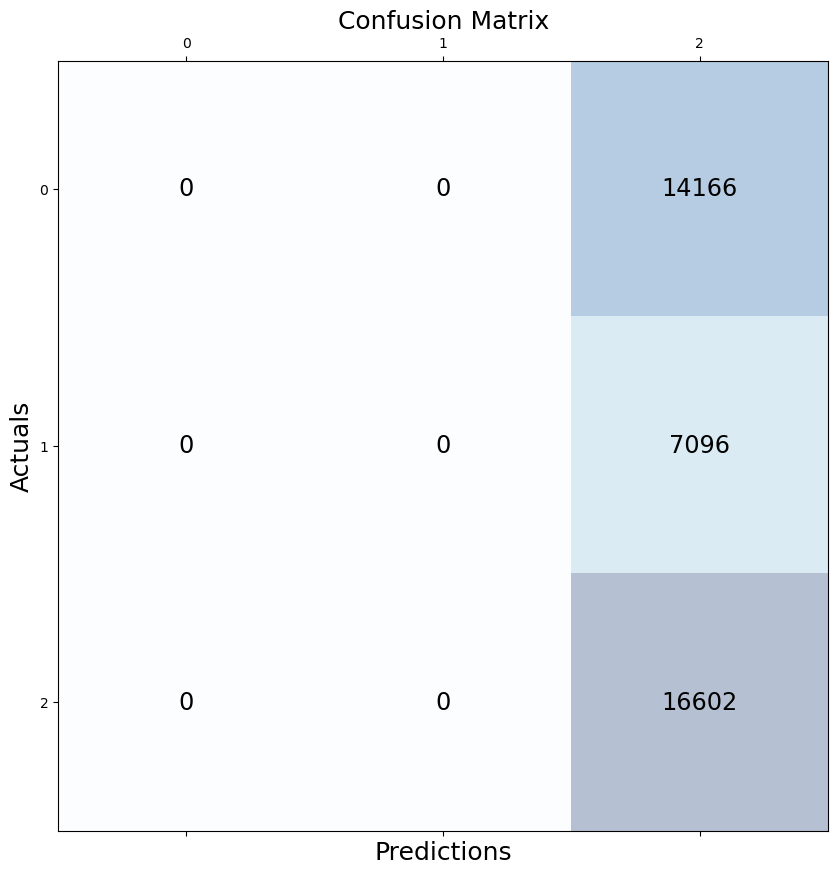

In [235]:
random_cm = np.array([ [0 for i in range(no_of_labels)] for j in range(no_of_labels)])
compute_random_predictor_accuracy(df_test, no_of_labels, random_cm)
draw_confusion_matrix(random_cm, "random_test") 

allpositive_cm = np.array([ [0 for i in range(no_of_labels)] for j in range(no_of_labels)])
compute_allpositive_predictor_accuracy(df_test, no_of_labels, allpositive_cm)
draw_confusion_matrix(allpositive_cm, "allpositive_test" )

random_cm = np.array([ [0 for i in range(no_of_labels)] for j in range(no_of_labels)])
compute_random_predictor_accuracy(df, no_of_labels, random_cm)
draw_confusion_matrix(random_cm, "random_training") 

allpositive_cm = np.array([ [0 for i in range(no_of_labels)] for j in range(no_of_labels)])
compute_allpositive_predictor_accuracy(df, no_of_labels, allpositive_cm)
draw_confusion_matrix(allpositive_cm, "allpositive_training" )


for all cases, class 2 or "Positive" has the highest value of diagonal entry 
This means that the maximum number of correct predictions have been made for "Positive" label.